In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance
from AlgorithmImports import *
sns.set()

ModuleNotFoundError: No module named 'AlgorithmImports'

In [13]:
spy = yfinance.Ticker('spy')
df = spy.history(period='1y')
df.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2022-06-30,376.239990,380.660004,372.559998,377.250000,112508300,0.0,0
2022-07-01,376.559998,381.700012,373.799988,381.239990,74792100,0.0,0
2022-07-05,375.880005,381.980011,372.899994,381.959991,81438000,0.0,0
2022-07-06,382.109985,385.869995,379.600006,383.250000,70326400,0.0,0
2022-07-07,382.109985,387.260010,385.119995,387.109985,5567635,0.0,0


In [14]:
def abcd(trend, skip_loop = 4, ma = 7):
    ma = pd.Series(trend).rolling(ma).mean().values
    x = []
    for a in range(ma.shape[0]):
        for b in range(a, ma.shape[0], skip_loop):
            for c in range(b, ma.shape[0], skip_loop):
                for d in range(c, ma.shape[0], skip_loop):
                    if ma[b] > ma[a] and \
                    (ma[c] < ma[b] and ma[c] > ma[a]) \
                    and ma[d] > ma[b]:
                        x.append([a,b,c,d])
    x_np = np.array(x)
    ac = x_np[:,0].tolist() + x_np[:,2].tolist()
    bd = x_np[:,1].tolist() + x_np[:,3].tolist()
    ac_set = set(ac)
    bd_set = set(bd)
    signal = np.zeros(len(trend))
    buy = list(ac_set - bd_set)
    sell = list(list(bd_set - ac_set))
    signal[buy] = 1.0
    signal[sell] = -1.0
    return signal

In [15]:
%%time
signal = abcd(df['Close'])

Wall time: 883 ms


In [16]:
def buy_stock(
    real_movement,
    signal,
    initial_money = 10000,
    max_buy = 1,
    max_sell = 1,
):
    """
    real_movement = actual movement in the real world
    delay = how much interval you want to delay to change our decision from buy to sell, vice versa
    initial_state = 1 is buy, 0 is sell
    initial_money = 10000, ignore what kind of currency
    max_buy = max quantity for share to buy
    max_sell = max quantity for share to sell
    """
    starting_money = initial_money
    states_sell = []
    states_buy = []
    states_money = []
    current_inventory = 0
    
    def buy(i, initial_money, current_inventory):
        shares = initial_money // real_movement[i]
        if shares < 1:
            print(
                'day %d: total balances %f, not enough money to buy a unit price %f'
                % (i, initial_money, real_movement[i])
            )
        else:
            if shares > max_buy:
                buy_units = max_buy
            else:
                buy_units = shares
            initial_money -= buy_units * real_movement[i]
            current_inventory += buy_units
            print(
                'day %d: buy %d units at price %f, total balance %f'
                % (i, buy_units, buy_units * real_movement[i], initial_money)
            )
            states_buy.append(0)
        return initial_money, current_inventory
    
    for i in range(real_movement.shape[0]):
        state = signal[i]
        if state == 1:
            initial_money, current_inventory = buy(
                i, initial_money, current_inventory
            )
            states_buy.append(i)
        elif state == -1:
            if current_inventory == 0:
                    print('day %d: cannot sell anything, inventory 0' % (i))
            else:
                if current_inventory > max_sell:
                    sell_units = max_sell
                else:
                    sell_units = current_inventory
                current_inventory -= sell_units
                total_sell = sell_units * real_movement[i]
                initial_money += total_sell
                try:
                    invest = (
                        (real_movement[i] - real_movement[states_buy[-1]])
                        / real_movement[states_buy[-1]]
                    ) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell %d units at price %f, investment %f %%, total balance %f,'
                    % (i, sell_units, total_sell, invest, initial_money)
                )
            states_sell.append(i)
        states_money.append(initial_money)
            
    invest = ((initial_money - starting_money) / starting_money) * 100
    total_gains = initial_money - starting_money
    return states_buy, states_sell, total_gains, invest, states_money

In [17]:
states_buy, states_sell, total_gains, invest, states_money = buy_stock(df.Close, signal)

day 6: buy 1 units at price 428.655396, total balance 9571.344604
day 7: buy 1 units at price 425.293213, total balance 9146.051392
day 8: buy 1 units at price 419.012482, total balance 8727.038910
day 9: buy 1 units at price 425.017120, total balance 8302.021790
day 10: buy 1 units at price 428.458160, total balance 7873.563629
day 11: buy 1 units at price 429.355438, total balance 7444.208191
day 12: buy 1 units at price 433.772644, total balance 7010.435547
day 14: buy 1 units at price 432.855682, total balance 6577.579865
day 63: buy 1 units at price 428.396576, total balance 6149.183289
day 64: buy 1 units at price 430.177032, total balance 5719.006256
day 66: buy 1 units at price 433.104858, total balance 5285.901398
day 91, sell 1 units at price 462.195465, investment 6.716758 %, total balance 5748.096863,
day 95, sell 1 units at price 464.628815, investment 7.278597 %, total balance 6212.725677,
day 96, sell 1 units at price 463.797913, investment 7.086749 %, total balance 6676

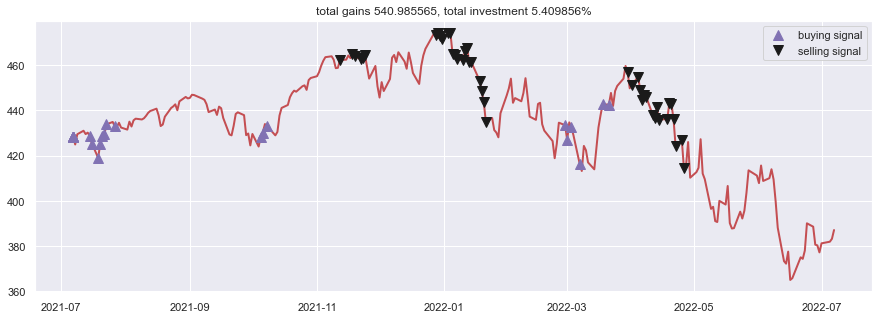

In [18]:
close = df['Close']
fig = plt.figure(figsize = (15,5))
plt.plot(close, color='r', lw=2.)
plt.plot(close, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(close, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('total gains %f, total investment %f%%'%(total_gains, invest))
plt.legend()
plt.show()

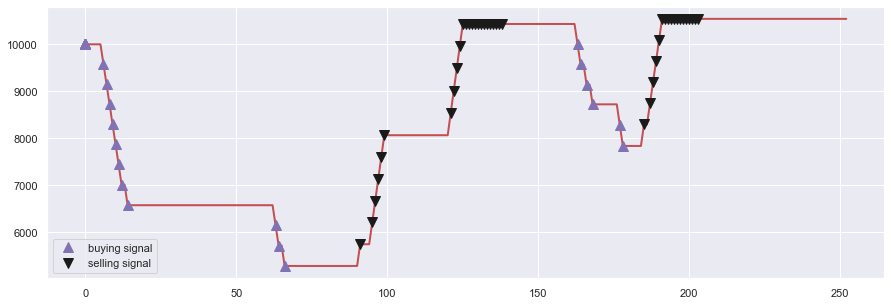

In [19]:
fig = plt.figure(figsize = (15,5))
plt.plot(states_money, color='r', lw=2.)
plt.plot(states_money, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(states_money, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.legend()
plt.show()

In [25]:
close.to_csv('SRTest.csv')